# Model training for NFL play prediction

---
 
In this notebook, we train multiple regression and ANN models to predict the yards gained per football play. As a basis we use the preselected data created by the `preprocessing.py``.

### Inline preprocessing steps:

---

As we use 5-fold cross-validation to protect the model against overfitting, we need a dynamic preprocessing appraoch. Therefore a pipeline provided by the `preprocessing.py`` will be used to process the training data of each fold. Further we use a nested cross validation to ensure the quality of our model using selected hyperparameters.


### Contributors

All contributors are only assigned to their primary task, the teams still interchanged know-how and worked on one anothers approaches.

---

##### Preprocessing Team

- Tim Oliver Krause (1689074)
- Jan Thilo Viktorin (1684159)
- Joël Pflomm (1634591)

##### Model Team

- Franziska Köllschen (1981780)
- Steffen Hüls (1979863)
- Matthias Biermanns (1980701)

## Coding

### Baseline estimation

### Coding Foundations

In [1]:
# basic imports
import pandas as pd
import numpy as np

# import for data visualization
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.tree import export_graphviz
from subprocess import call

# import for preprocessing
import preprocessing
from sklearn.pipeline import Pipeline

# import used models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# imports for evaluation
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, ParameterGrid
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# static variables
FILE_LIST = [f'./Data/play_by_play_{year}.csv' for year in range(1999, 2024)]
PREPROCESSOR = preprocessing.NFLPreprocessing(FILE_LIST)
TARGET_NAME = 'yards_gained'
PRED_SAVE_NAME = 'predicted yards_gained'
RANDOM_STATE = 42
LABEL_PASS = 'Pass'
LABEL_RUN = 'Run'

# global variables to save files
model_counter = 0
plot_counter = 0

2023-12-08 15:30:05.617 | INFO     | preprocessing:__init__:59 - --- Executing Preprocessing Steps ---
2023-12-08 15:30:05.622 | INFO     | preprocessing:make_combined_df:148 - Loading csv files
c:\Users\thilo\Documents\Uni\Master\1. Semester\Data Mining I\Team Project\NFL_play_prediction\preprocessing.py:153: DtypeWarning: Columns (36,37,179,180,189,190,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
c:\Users\thilo\Documents\Uni\Master\1. Semester\Data Mining I\Team Project\NFL_play_prediction\preprocessing.py:153: DtypeWarning: Columns (37,45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,248,249,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
c:\Users\thilo\Documents\Uni\Master\1. Semester\Data Mining I\Team Pr

##### General functions

In [3]:
def get_sample(df: pd.DataFrame, data_fraction: float):
    """
    Sample a fraction of the DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - data_fraction (float): Fraction of the DataFrame to sample, should be between 0 and 1.

    Returns:
    pd.DataFrame: A sampled DataFrame.

    Example:
    sampled_df = sample_dataframe(df, 0.2)
    """
    # set fraction between 0 and 1 (e.g. 0.05 -> 5% df)
    df_sampled = df.sample(frac=data_fraction, random_state=RANDOM_STATE)

    # Reset the index if needed
    df_sampled = df_sampled.reset_index(drop=True)

    return df_sampled

def split_feature_target(df: pd.DataFrame):
    """
    Split the input DataFrame into features and target.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    tuple: A tuple containing two DataFrames - features and target.

    Example:
    features, target = split_feature_target(df)
    """
    features = df.drop(TARGET_NAME, axis=1)
    target = df[TARGET_NAME]

    return features, target

def plot_predicts(y_test, predictions, label: str):
    """
    Plot actual vs. predicted values and display regression metrics.
    
    Parameters:
    - y_test (array-like): True values.
    - predictions (array-like): Predicted values.
    - label (str): Label for the plot.

    Returns:
    None

    Example:
    plot_predicts(y_true, y_pred, "Linear Regression")
    """
    # print metrics
    pass_mse = mean_squared_error(y_test, predictions)
    pass_rmse = mean_squared_error(y_test, predictions, squared = False)
    pass_msa = mean_absolute_error(y_test, predictions)

    # Visualize predictions for passes
    plt.scatter(y_test, predictions)
    plt.title(label + ' Model: True vs Predicted Yards')
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

    print(f"Mean Squared Error: {pass_mse}")
    print(f"Mean Absolute Error: {pass_msa}")
    print(f"Root Mean Squared Error: {pass_rmse}")

def plot_decision_tree(pipeline, label: str, target_tree: int = 0):
    """
    Plot a decision tree from a pipeline.
    
    Parameters:
    - pipeline: A pipeline containing a decision tree regressor.
    - label (str): Label for the plot.
    - target_tree (int): Index of the tree to plot.

    Returns:
    None

    Example:
    plot_decision_tree(pipeline, "Random Forest")
    """
    global plot_counter
    fileName = f'./results/plot_{plot_counter}_{label}_rf'
    # Export the decision tree as a dot file
    export_graphviz(pipeline.named_steps['regressor'].estimators_[target_tree], out_file=f'{fileName}.dot', 
                    feature_names=PREPROCESSOR.get_prepro_feature_names_from_pipeline(),
                    rounded=True, proportion=False, 
                    precision=2, filled=True)

    # Convert the dot file to png using Graphviz (make sure Graphviz is installed)
    call(['dot', '-Tpng', f'{fileName}.dot', '-o', f'{fileName}.png', '-Gdpi=600'])

    plot_counter = plot_counter + 1

    display(Image(filename=f'{fileName}.png'))

def plot_decision_tree_xgb(pipeline, label: str, target_tree: int=0):
    """
    Plot an XGBoost decision tree from a pipeline.
    
    Parameters:
    - pipeline: A pipeline containing an XGBoost regressor.
    - label (str): Label for the plot.
    - target_tree (int): Index of the tree to plot.

    Returns:
    None

    Example:
    plot_decision_tree_xgb(pipeline, "XGBoost")
    """
    global plot_counter
    fileName = f'./results/plot_{plot_counter}_{label}_xgb'

    xgb.plot_tree(pipeline.named_steps['regressor'], num_trees=target_tree, fmap='featureMap.txt')
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    fig.canvas.manager.set_window_title('Decision Tree for ' + label + ' Model')
    fig.savefig(f'{fileName}.png')
    
    plot_counter = plot_counter + 1

    Image(filename=f'{fileName}.png')

def plot_train_val_loss(training_losses: list, validation_losses: list, label: str):
    """
    Plot training and validation loss for a neural network.

    Parameters:
    - training_losses (list): Training loss values.
    - validation_losses (list): Validation loss values.
    - label (str): Label for the plot.

    Returns:
    None

    Example:
    plot_train_val_loss(train_loss, val_loss, "Neural Network")
    """
    global plot_counter
    fileName = f'./results/plot_{plot_counter}_{label}_ann'
    # Plot the training and validation loss
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss - ' + label)
    plt.legend()
    plt.savefig(f'{fileName}.png')
    plt.show()
    plot_counter = plot_counter + 1

def plot_feature_importances(pipeline, label: str, show_top_n: int=10):
    """
    Plot feature importances from a pipeline.
    
    Parameters:
    - pipeline: A pipeline containing a model with feature importances.
    - label (str): Label for the plot.
    - show_top_n (int): Number of top features to display.

    Returns:
    None

    Example:
    plot_feature_importances(pipeline, "Random Forest")
    """
    global plot_counter
    fileName = f'./results/plot_{plot_counter}_{label}_feature_importance'
    # Get feature importances
    feature_importances = pipeline.named_steps['regressor'].feature_importances_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    # Create a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'][:show_top_n], feature_importance_df['Importance'][:show_top_n])
    plt.xlabel('Importance')
    plt.title(f'Top {show_top_n} Feature Importances - {label}')
    plt.savefig(f'{fileName}.png')
    plt.show()
    plot_counter = plot_counter + 1

def plot_coef(pipeline, label: str):
    """
    Plot coefficients from a linear regression pipeline.
    Parameters:
    - pipeline: A pipeline containing a linear regression model.
    - label (str): Label for the plot.

    Returns:
    None

    Example:
    plot_coef(pipeline, "Linear Regression")
    """
    global plot_counter
    fileName = f'./results/plot_{plot_counter}_{label}_feature_importance'
    coefs = pipeline.named_steps['regressor'].coef_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    coef = pd.DataFrame(coefs, columns=["Coefficients"], index=columns)
    coef.plot(kind="barh", figsize=(9, 7))
    plt.savefig(f'{fileName}.png')
    plt.show()
    plot_counter = plot_counter + 1

def estimate_model_from_excel(path: str):
    """
    Load data from an Excel file, estimate model predictions, and plot the results.

    Returns:
    None

    Example:
    estimate_model_from_excel("path/to/excel/file.xlsx")
    """
    df = pd.read_excel(path)

    # drop na-rows if for some datarows no prediction has been made
    df = df.dropna()
    label = path.split('_')[2]

    target = df[TARGET_NAME]
    predictions = df[PRED_SAVE_NAME]

    plot_predicts(target, predictions, label)

##### Functions for cross validation

In [4]:
def test_model(pipeline, df: pd.DataFrame, data_fraction: float = None, label = None):
    """
    Test a machine learning model using a specified pipeline.
    Parameters:
    - pipeline: The machine learning model pipeline.
    - df (pd.DataFrame): The input DataFrame.
    - data_fraction (float, optional): Fraction of the DataFrame to use for testing. Default is None.
    - label (str, optional): Label for the plot and saved model file. Default is None.

    Returns:
    tuple: A tuple containing true values and predicted values.

    Example:
    y_true, y_pred = test_model(pipeline, df, data_fraction=0.2, label="Random Forest")
    """
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(data, data_fraction)
    
    features, target = split_feature_target(data)
    X_train, X_test, y_train, y_test = train_test_split(features, target)

    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipeline.predict(X_test)

    plot_predicts(y_test, predictions, label if label else '')
    save_model(features, target, predictions, label, title_appendix=f'normal_{data_fraction*100}%_of_data')

    return y_test, predictions

def test_model_k_fold(df: pd.DataFrame, pipeline, label: str, k_folds: int=3, data_fraction: float = 1.0):
    """
    Test a machine learning model using k-fold cross-validation.
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - pipeline: The machine learning model pipeline.
    - label (str): Label for the plot and saved model file.
    - k_folds (int, optional): Number of folds for cross-validation. Default is 3.
    - data_fraction (float, optional): Fraction of the DataFrame to use for testing. Default is 1.0.

    Returns:
    array-like: Predicted values from cross-validation.

    Example:
    cv_predictions = test_model_k_fold(df, pipeline, "Random Forest", k_folds=5, data_fraction=0.8)
    """
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(df, data_fraction)
    
    features, target = split_feature_target(data)

    cv_predictions = cross_val_predict(pipeline, features, target, cv=k_folds)
    
    plot_predicts(target, cv_predictions, label)
    save_model(features, target, cv_predictions, label, title_appendix=f'{k_folds}_folds_{data_fraction*100}%_of_data')
    return cv_predictions

def estimate_hyperparams(df: pd.DataFrame, pipeline, scoring: str, label: str, k_folds: int=3, parameters: dict={}, data_fraction: float = 1.0):
    """
    Estimate hyperparameters using grid search and cross-validation.
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - pipeline: The machine learning model pipeline.
    - scoring (str): Scoring metric for grid search.
    - label (str): Label for saving results.
    - k_folds (int, optional): Number of folds for cross-validation. Default is 3.
    - parameters (dict, optional): Hyperparameter grid for grid search. Default is an empty dictionary.
    - data_fraction (float, optional): Fraction of the DataFrame to use for testing. Default is 1.0.

    Returns:
    GridSearchCV: Grid search estimator.

    Example:
    grid_search_estimator = estimate_hyperparams(df, pipeline, "neg_mean_squared_error", "Random Forest", k_folds=5, parameters={'n_estimators': [50, 100, 200]})
    """
    global model_counter
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(df, data_fraction)

    features, target = split_feature_target(data)
    
    # create the grid search instance
    grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=scoring, cv=k_folds, return_train_score=False, n_jobs=1)

    # run the grid search
    grid_search_estimator.fit(features, target)
    
    cv_results_df = pd.DataFrame(grid_search_estimator.cv_results_)
    cv_results_df.to_excel(f'./results/model_{model_counter}_{label}_nestedCV_{data_fraction*100}%_of_data.xlsx')
    model_counter = model_counter + 1
    display(grid_search_estimator.best_params_)
    display(cv_results_df)

    return grid_search_estimator

def generate_param_combinations(parameters: dict):
    """
    Generate combinations of hyperparameters for grid search.
    Parameters:
    - parameters (dict): Hyperparameter grid.

    Returns:
    list: List of dictionaries representing hyperparameter combinations.

    Example:
    param_combinations = generate_param_combinations({'n_estimators': [50, 100], 'max_depth': [None, 10]})
    """
    return list(ParameterGrid(parameters))

def save_model(features: pd.DataFrame, target: pd.Series, predictions, label: str, title_appendix: str = ''):
    """
    Save model results (features, target, predictions) to an Excel file.

    Parameters:
    - features (pd.DataFrame): Features used in the model.
    - target (pd.Series): Target variable.
    - predictions (array-like): Model predictions.
    - label (str): Label for the saved file.
    - title_appendix (str, optional): Appendix to the title for differentiation. Default is an empty string.

    Returns:
    None

    Example:
    save_model(features, target, predictions, "Random Forest", title_appendix="normal_20%_of_data")
    """
    global model_counter

    predictions_df = pd.DataFrame({'predicted yards_gained': predictions})
    save_model = pd.concat([features, target, predictions_df], axis=1)

    if (title_appendix != ''):
        title_appendix = '_'+title_appendix
    save_model.to_excel(f'./results/model_{model_counter}_{label}{title_appendix}.xlsx')

    # increase counter for files
    model_counter = model_counter + 1
    pass

##### MLP Regressor Class - with history

In [5]:
class MLPWithHistory(BaseEstimator, TransformerMixin):
    def __init__(self, mlp_params=None):
        self.mlp_params = mlp_params
        self.training_losses = []
        self.validation_losses = []
        self.mlp_regressor = MLPRegressor(**(self.mlp_params or {}))

    def fit(self, X, y):
        X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        for epoch in range(self.mlp_regressor.max_iter):
            self.mlp_regressor.partial_fit(X, y)

            # Calculate training loss
            y_train_pred = self.mlp_regressor.predict(X)
            training_loss = mean_squared_error(y, y_train_pred)
            self.training_losses.append(training_loss)

            # Calculate validation loss
            y_val_pred = self.mlp_regressor.predict(X_val)
            validation_loss = mean_squared_error(y_val, y_val_pred)
            self.validation_losses.append(validation_loss)

        return self

    def transform(self, X):
        return X

    def predict(self, X):
        return self.mlp_regressor.predict(X)

    def get_params(self, deep=True):
        return {"mlp_params": self.mlp_params}

    def set_params(self, **params):
        self.mlp_params = params["mlp_params"]
        self.mlp_regressor.set_params(**self.mlp_params)
        return self
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)

##### Train and Test Data

In [6]:
# fetching the selected dataset from the preprocessor class
run_df = PREPROCESSOR.run_df
pass_df = PREPROCESSOR.pass_df

# split data into feature and target
run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# print initial information
print(run_features.shape)
print(pass_features.shape)

(338011, 24)
(441658, 24)


### Baseline Estimation

In [7]:
# calculating median of selected data
median_run = np.median(run_target)
median_pass = np.median(pass_target)

# estimating metrics
mse_run_baseline = mean_squared_error(run_target, np.full_like(run_target, median_run))
mse_pass_baseline = mean_squared_error(pass_target, np.full_like(pass_target, median_pass))

rmse_run_baseline = np.sqrt(mse_run_baseline)
rmse_pass_baseline = np.sqrt(mse_pass_baseline)

mae_run_baseline = mean_absolute_error(run_target, np.full_like(run_target, median_run))
mae_pass_baseline = mean_absolute_error(pass_target, np.full_like(pass_target, median_pass))

# print metrics
print("Run Dataset Baseline Metrics:")
print("Mean Squared Error (MSE) baseline:", mse_run_baseline)
print("Root Mean Squared Error (RMSE) baseline:", rmse_run_baseline)
print("Mean Absolute Error (MAE) baseline:", mae_run_baseline)

print("Pass Dataset Baseline Metrics:")
print("Mean Squared Error (MSE) baseline:", mse_pass_baseline)
print("Root Mean Squared Error (RMSE) baseline:", rmse_pass_baseline)
print("Mean Absolute Error (MAE) baseline:", mae_pass_baseline)

Run Dataset Baseline Metrics:
Mean Squared Error (MSE) baseline: 41.28444044720438
Root Mean Squared Error (RMSE) baseline: 6.425296915100841
Mean Absolute Error (MAE) baseline: 3.6418193490744386
Pass Dataset Baseline Metrics:
Mean Squared Error (MSE) baseline: 109.598469856767
Root Mean Squared Error (RMSE) baseline: 10.468928782677194
Mean Absolute Error (MAE) baseline: 6.844796199774486


### Linear Regression

#### Normal Linear Regression

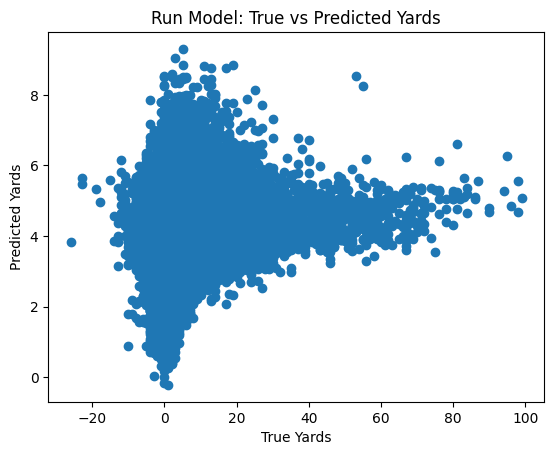

Mean Squared Error: 40.34207566996714
Mean Absolute Error: 3.818831585187992
Root Mean Squared Error: 6.351541204303656


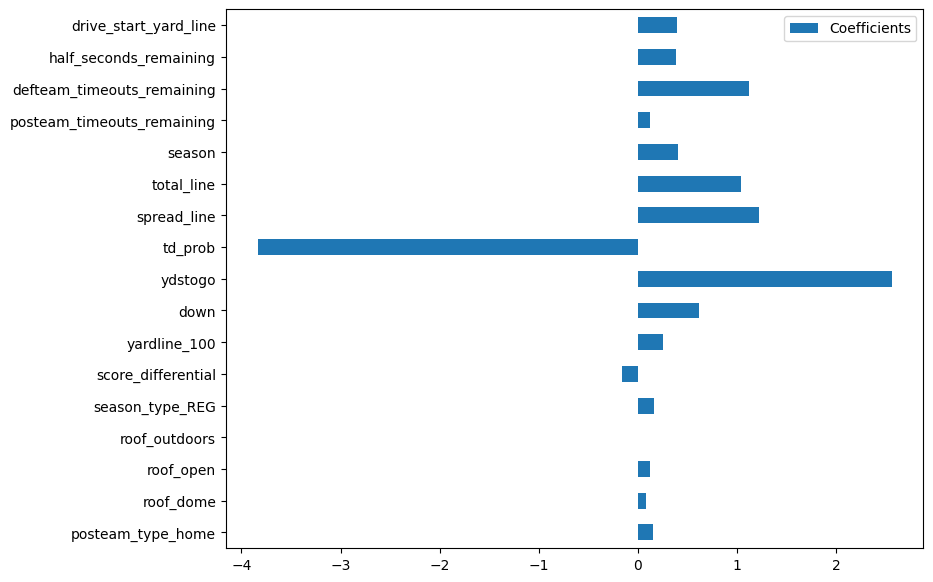

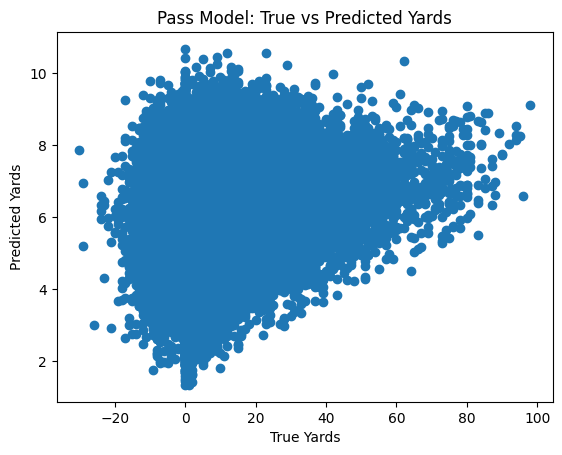

Mean Squared Error: 96.9332470294091
Mean Absolute Error: 7.010352553474342
Root Mean Squared Error: 9.845468349926737


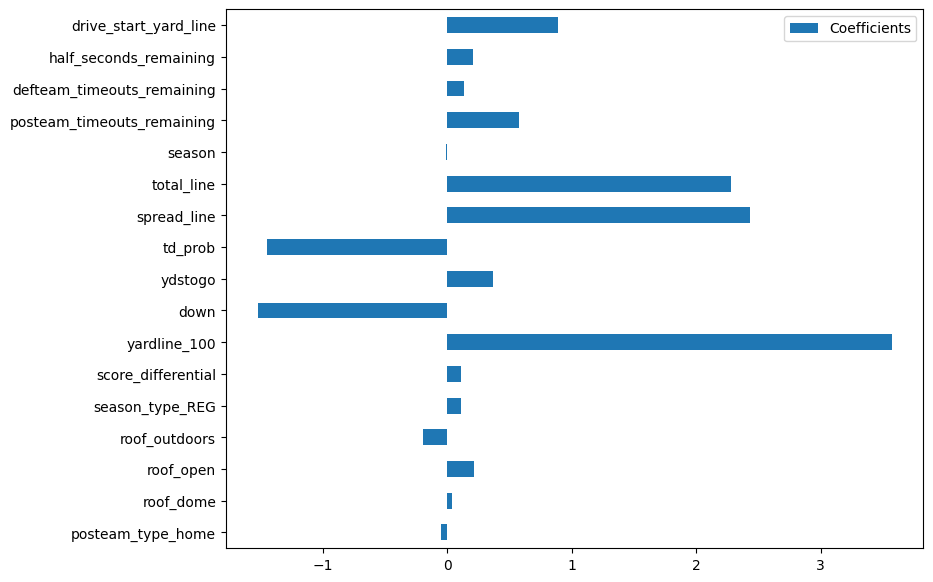

In [9]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

# set params, test model and save predictions
run_y_test, run_predictions = test_model(pipeline, run_df, 1.0, label=LABEL_RUN)
plot_coef(pipeline, LABEL_RUN)

# set params, test model and save predictions
pass_y_test, pass_predictions = test_model(pipeline, pass_df, 1.0, label=LABEL_PASS)
plot_coef(pipeline, LABEL_PASS)

In [10]:
# hyperparameter tuning for linear regression
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

parameters = {
    'regressor__fit_intercept': [True, False],
    #'regressor__random_state': [RANDOM_STATE],
    'outlier_remover__kw_args': [
        {
            'save_stats': False,
        }
    ]
}

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_root_mean_squared_error', LABEL_RUN, parameters=parameters, data_fraction=1.0)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_root_mean_squared_error', LABEL_PASS, parameters=parameters, data_fraction=1.0)

ValueError: Invalid parameter 'random_state' for estimator LinearRegression(). Valid parameters are: ['copy_X', 'fit_intercept', 'n_jobs', 'positive'].

In [ ]:
logging_params = {
    'outlier_remover__kw_args': {
        'save_stats': True,
    }
}

# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = run_grid_search.best_params_
run_params.update(logging_params)

pass_params = pass_grid_search.best_params_
pass_params.update(logging_params)

# set params, test model and save predictions
run_pipeline = run_pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, run_pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pass_pipeline = pass_pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pass_pipeline, LABEL_PASS, data_fraction=1.0)

In [ ]:
# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
run_pipeline = run_pipeline.set_params(**run_params)
run_predictions = test_model(run_pipeline, run_df, label = LABEL_RUN, data_fraction=1.0)

plot_coef(run_pipeline, LABEL_RUN)

# set params, test model and save predictions
pass_pipeline = pass_pipeline.set_params(**pass_params)
pass_predictions = test_model(pass_pipeline, pass_df, label = LABEL_PASS, data_fraction=1.0)

plot_coef(pass_pipeline, LABEL_PASS)

#### Ridge Regression

In [ ]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(Ridge())

# set params, test model and save predictions
run_y_test, run_predictions = test_model(pipeline, run_df, 1.0, label=LABEL_RUN)
plot_coef(pipeline, LABEL_RUN)

# set params, test model and save predictions
pass_y_test, pass_predictions = test_model(pipeline, pass_df, 1.0, label=LABEL_PASS)
plot_coef(pipeline, LABEL_PASS)

In [ ]:
# hyperparameter tuning for linear regression

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Ridge())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Ridge())

parameters = {
    'regressor__alpha': [x / 10.0 for x in range(6, 15, 2)],
    'regressor__fit_intercept': [True, False],
    'regressor__max_iter': [1000, 7500, 15000],
    'regressor__tol': [0.0001, 0.0005, 0.001],
#    'regressor__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    'regressor__random_state': [RANDOM_STATE],
    'outlier_remover__kw_args': [
        {
            'save_stats': False,
        }
    ]
}

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_root_mean_squared_error', LABEL_RUN, parameters=parameters, data_fraction=1.0)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_root_mean_squared_error', LABEL_PASS, parameters=parameters, data_fraction=1.0)

In [ ]:
# hyperparameter tuning for linear regression
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Ridge())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Ridge())

# same again for run and pass, as both have the same best params
parameters = {
    'regressor__alpha': [x / 10.0 for x in range(12, 21, 1)],
    'regressor__fit_intercept': [True, False],
    'regressor__max_iter': [800, 900, 1000, 1100, 1200],
    'regressor__tol': [0.00008, 0.00009, 0.0001, 0.00011, 0.00012],
    'regressor__random_state': [RANDOM_STATE],
    'outlier_remover__kw_args': [
        {
            'save_stats': False,
        }
    ]
}

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_root_mean_squared_error', LABEL_RUN, parameters=parameters, data_fraction=1.0)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_root_mean_squared_error', LABEL_PASS, parameters=parameters, data_fraction=1.0)

In [ ]:
logging_params = {
    'outlier_remover__kw_args': {
        'save_stats': True,
    }
}

# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Ridge())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Ridge())

run_params = run_grid_search.best_params_
run_params.update(logging_params)

pass_params = pass_grid_search.best_params_
pass_params.update(logging_params)

# set params, test model and save predictions
run_pipeline = run_pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, run_pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pass_pipeline = pass_pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pass_pipeline, LABEL_PASS, data_fraction=1.0)

In [ ]:
# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Ridge())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Ridge())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
run_pipeline = run_pipeline.set_params(**run_params)
run_predictions = test_model(run_pipeline, run_df, label = LABEL_RUN, data_fraction=1.0)

plot_coef(run_pipeline, LABEL_RUN)

# set params, test model and save predictions
pass_pipeline = pass_pipeline.set_params(**pass_params)
pass_predictions = test_model(pass_pipeline, pass_df, label = LABEL_PASS, data_fraction=1.0)

plot_coef(pass_pipeline, LABEL_PASS)

#### Lasso Regression

In [ ]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(Lasso())

# set params, test model and save predictions
run_y_test, run_predictions = test_model(pipeline, run_df, 1.0, label=LABEL_RUN)
plot_coef(pipeline, LABEL_RUN)

# set params, test model and save predictions
pass_y_test, pass_predictions = test_model(pipeline, pass_df, 1.0, label=LABEL_PASS)
plot_coef(pipeline, LABEL_PASS)

In [ ]:
# hyperparameter tuning for Lasso regression

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Lasso())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Lasso())

parameters = {
    'regressor__alpha': [x / 10.0 for x in range(6, 15, 2)],
    'regressor__fit_intercept': [True, False],
    'regressor__max_iter': [800, 900, 1000, 1100, 1200],
    'regressor__tol': [0.00005, 0.0001, 0.00015],
    'regressor__warm_start': [True, False],
    'regressor__random_state': [RANDOM_STATE],
    'regressor__selection': ['cyclic', 'random'],
    'outlier_remover__kw_args': [
        {
            'save_stats': False,
        }
    ]
}

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_root_mean_squared_error', LABEL_RUN, parameters=parameters, data_fraction=1.0)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_root_mean_squared_error', LABEL_PASS, parameters=parameters, data_fraction=1.0)

In [ ]:
logging_params = {
    'outlier_remover__kw_args': {
        'save_stats': True,
    }
}

# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Lasso())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Lasso())

run_params = run_grid_search.best_params_
run_params.update(logging_params)

pass_params = pass_grid_search.best_params_
pass_params.update(logging_params)

# set params, test model and save predictions
run_pipeline = run_pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, run_pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pass_pipeline = pass_pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pass_pipeline, LABEL_PASS, data_fraction=1.0)

In [ ]:
# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Lasso())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(Lasso())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
run_pipeline = run_pipeline.set_params(**run_params)
run_predictions = test_model(run_pipeline, run_df, label = LABEL_RUN, data_fraction=1.0)

plot_coef(run_pipeline, LABEL_RUN)

# set params, test model and save predictions
pass_pipeline = pass_pipeline.set_params(**pass_params)
pass_predictions = test_model(pass_pipeline, pass_df, label = LABEL_PASS, data_fraction=1.0)

plot_coef(pass_pipeline, LABEL_PASS)

In [ ]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

# set params, test model and save predictions
run_y_test, run_predictions = test_model(pipeline, run_df, 1.0, label=LABEL_RUN)
plot_coef(pipeline, LABEL_RUN)

# set params, test model and save predictions
pass_y_test, pass_predictions = test_model(pipeline, pass_df, 1.0, label=LABEL_PASS)
plot_coef(pipeline, LABEL_PASS)

In [ ]:
# hyperparameter tuning for linear regression

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

parameters = {
    'regressor__fit_intercept': [True, False],
    'outlier_remover__kw_args': [
        {
            'save_stats': False,
        }
    ]
}

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_root_mean_squared_error', LABEL_RUN, parameters=parameters, data_fraction=1.0)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_root_mean_squared_error', LABEL_PASS, parameters=parameters, data_fraction=1.0)

In [ ]:
logging_params = {
    'outlier_remover__kw_args': {
        'save_stats': True,
    }
}

# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = run_grid_search.best_params_
run_params.update(logging_params)

pass_params = pass_grid_search.best_params_
pass_params.update(logging_params)

# set params, test model and save predictions
run_pipeline = run_pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, run_pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pass_pipeline = pass_pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pass_pipeline, LABEL_PASS, data_fraction=1.0)

In [ ]:
# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
run_pipeline = run_pipeline.set_params(**run_params)
run_predictions = test_model(run_pipeline, run_df, label = LABEL_RUN, data_fraction=1.0)

plot_coef(run_pipeline, LABEL_RUN)

# set params, test model and save predictions
pass_pipeline = pass_pipeline.set_params(**pass_params)
pass_predictions = test_model(pass_pipeline, pass_df, label = LABEL_PASS, data_fraction=1.0)

plot_coef(pass_pipeline, LABEL_PASS)

### Polynomial Regression

In [ ]:
# basic model

# make pipelines from preprocessing script
poly_pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures()), ('linear_regression', LinearRegression())])
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(poly_pipeline)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(poly_pipeline)

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.25, label=LABEL_RUN)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.25, label=LABEL_PASS)

In [ ]:
# make new pipeliness from preprocessing script
poly_pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures()), ('linear_regression', LinearRegression())])
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(poly_pipeline)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(poly_pipeline)

parameters = {
    'regressor__polynomialfeatures__degree': list(range(2,5)) + [(x, x) for x in range(2,5)],
    'regressor__polynomialfeatures__interaction_only': [True, False],
    'regressor__polynomialfeatures__include_bias': [True, False],
    'outlier_remover__kw_args': [
        {
            'save_stats': False,
        }
    ]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', LABEL_RUN, parameters=parameters, data_fraction=0.5)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', LABEL_PASS, parameters=parameters, data_fraction=0.5)

In [ ]:
# cross-validation with best hyperparameters

logging_params = {
    'outlier_remover__kw_args': {
        'save_stats': True,
    }
}

# make new pipeliness from preprocessing script
poly_pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures()), ('linear_regression', LinearRegression())])
pipeline = PREPROCESSOR.make_preprocessing_pipeline(poly_pipeline)

run_params = run_grid_search.best_params_
run_params.update(logging_params)

pass_params = pass_grid_search.best_params_
pass_params.update(logging_params)

# set params, test model and save predictions
run_pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, run_pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pass_pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pass_pipeline, LABEL_PASS, data_fraction=1.0)

### KNN

In [ ]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.2)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.2)

In [ ]:
# estimating hyperparameters
parameters = {
    'regressor__n_neighbors': range(5,10),
    'outlier_remover__kw_args': [
        {
            'strict_columns': ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall'],
        },
        {
            'strict_columns': [],
        }
    ]
}

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

# run grid search for run and pass with the whole dataset and the hyperparameters specified above
run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', 'KNN_RUN', k_folds=3, parameters=parameters, data_fraction=1.0)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', 'KNN_RUN', k_folds=3, parameters=parameters, data_fraction=1.0)

In [ ]:
# cross-validation with best hyperparameters

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

# get the best parameters from the hyperparameter tuning
run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions for run
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions for pass
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)

### Random Forest

In [ ]:
# Basic model
run_params = {
    'outlier_remover__kw_args': {
        'save_stats': False,
    }
}

pass_params = {
    'outlier_remover__kw_args': {
        'save_stats': False,
    }
}

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))

run_pipeline.set_params(**run_params)
pass_pipeline.set_params(**pass_params)

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.25, label=LABEL_RUN)
plot_feature_importances(run_pipeline, LABEL_RUN)

pass_y_test, pass_predictions = test_model(pass_pipeline, pass_df, 0.25, label=LABEL_PASS)
plot_feature_importances(pass_pipeline, LABEL_PASS)

In [ ]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

parameters = {
    'regressor__max_depth': [5, 10, 20],
    'regressor__n_estimators': [20, 50],
    'regressor__min_samples_split': [50, 100],
    'regressor__min_samples_leaf': [10, 20],
    'regressor__max_features': ['sqrt', 'log2', 1, None],
    'regressor__random_state': [RANDOM_STATE],
    'outlier_remover__kw_args': [
        {
            'save_stats': False,
        }
    ]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', LABEL_RUN, k_folds=3, parameters=parameters, data_fraction=1.0)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', LABEL_PASS, k_folds=3, parameters=parameters, data_fraction=1.0)

In [ ]:
# further estimating

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

# representing the best params from last round / the area next to it
run_parameters = {
    'regressor__max_depth': range(8, 13),
    'regressor__n_estimators': [45, 50, 55],
    'regressor__min_samples_split': [40, 50, 60],
    'regressor__min_samples_leaf': [20],
    'regressor__max_features': [None],
    'regressor__random_state': [RANDOM_STATE],
    'outlier_remover__kw_args': [
        {
            'save_stats': False,
        }
    ]
}

pass_parameters = {
    'regressor__max_depth': range(8, 13),
    'regressor__n_estimators': [45, 50, 55],
    'regressor__min_samples_split': [90, 100, 110],
    'regressor__min_samples_leaf': [10],
    'regressor__max_features': ['sqrt'],
    'regressor__random_state': [RANDOM_STATE],
    'outlier_remover__kw_args': [
        {
            'save_stats': False,
        }
    ]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', LABEL_RUN, k_folds=3, parameters=run_parameters, data_fraction=1.0)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', LABEL_PASS, k_folds=3, parameters=pass_parameters, data_fraction=1.0)

In [ ]:
# cross-validation with best hyperparameters

logging_params = {
    'outlier_remover__kw_args': {
        'save_stats': True,
    }
}

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

run_params = run_grid_search.best_params_
run_params.update(logging_params)

pass_params = pass_grid_search.best_params_
pass_params.update(logging_params)

# set params, test model and save predictions
run_pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, run_pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pass_pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pass_pipeline, LABEL_PASS, data_fraction=1.0)

In [ ]:
plot_feature_importances(run_pipeline, LABEL_RUN)

plot_feature_importances(run_pipeline, LABEL_RUN)

# Plot the decision tree for passes
plot_decision_tree(run_pipeline, LABEL_RUN)

# Plot the decision tree for runs
plot_decision_tree(pass_pipeline, LABEL_PASS)

### XGBoost

In [ ]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.022,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
                           )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.015,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
        )
)

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05)

# plot the feature importance for run and pass model
plot_feature_importances(run_pipeline, LABEL_RUN)
plot_feature_importances(pass_pipeline, LABEL_PASS)

In [ ]:
# estimating hyperparameters with testing outlier removals

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

# define the parameters that should be tested
parameters = {
    "regressor__max_depth":    [3, 4, 5],
    "regressor__n_estimators": [700, 800, 900],
    "regressor__learning_rate": [0.09, 0.01, 0.011],
    "regressor__gamma": [0, 5, 10],
    'outlier_remover__kw_args': [
        {
            'strict_columns': ['yardline_100', 'ydstogo', 'score_differential', 'td_prob', 'drive_play_count', 'drive_start_yard_line', 'spread_line', 'total_line', 'overall'],
        },
        {
            'strict_columns': [],
        }
    ]
}

# run grid search for the defined parameters, first of all with a smaller subset to also test the influence of the outlier removal on the model performance 
run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', 'XGB_RUN', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', 'XGB_RUN', k_folds=3, parameters=parameters, data_fraction=0.05)

In [ ]:
# estimating hyperparameters without testing outlier removals

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

# define the parameters that should be tested
parameters = {
    "regressor__max_depth":    [3, 6, 9],
    "regressor__n_estimators": [600, 800, 1000],
    "regressor__learning_rate": [0.09, 0.01, 0.011],
    "regressor__gamma": [0, 5, 10]
}

#run grid search now only with no columns set to strict for the outlier removal as that had given the better results above
run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', 'XGB_RUN', k_folds=3, parameters=parameters, data_fraction=0.25)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', 'XGB_RUN', k_folds=3, parameters=parameters, data_fraction=0.25)

In [ ]:
# training & testing the model with the best combination of hyperparameters using a 3 fold cross validation

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

# extracting the best hyperparameter set from the grid search done previously
run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model, save predictions and plot the feature importance
run_pipeline = run_pipeline.set_params(**run_params)
run_predictions = test_model(run_pipeline, run_df, 1.0)
plot_feature_importances(run_pipeline, LABEL_RUN)

# set params, test model, save predictions and plot the feature importance
pass_pipeline = pass_pipeline.set_params(**pass_params)
pass_predictions = test_model(pass_pipeline, pass_df, 1.0)
plot_feature_importances(pass_pipeline, LABEL_PASS)

In [ ]:
#getting more insights into the models

# Plot a decision tree for passes
plot_decision_tree_xgb(run_pipeline, LABEL_PASS)

# Plot a decision tree for runs
plot_decision_tree_xgb(pass_pipeline, LABEL_RUN)

# plot the feature importance of the pass model by using the weight, gain and the cover 
xgb.plot_importance(pass_pipeline.named_steps['regressor'], importance_type="weight", fmap='featureMap.txt')
xgb.plot_importance(pass_pipeline.named_steps['regressor'], importance_type="gain", fmap='featureMap.txt')
xgb.plot_importance(pass_pipeline.named_steps['regressor'], importance_type="cover", fmap='featureMap.txt')

# plot the feature importance of the run model by using the weight, gain and the cover 
xgb.plot_importance(run_pipeline.named_steps['regressor'], importance_type="weight", fmap='featureMap.txt')
xgb.plot_importance(run_pipeline.named_steps['regressor'], importance_type="gain", fmap='featureMap.txt')
xgb.plot_importance(run_pipeline.named_steps['regressor'], importance_type="cover", fmap='featureMap.txt')

### Artificial Neuronal Network

In [ ]:
# Basic model

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)

# estimate run model
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.2)
run_mlp = run_pipeline.named_steps['regressor']
plot_train_val_loss(run_mlp.training_losses, run_mlp.validation_losses, LABEL_RUN)

# estimate pass model
pass_y_test, pass_predictions = test_model(pass_pipeline, pass_df, 0.2)
pass_mlp = pass_pipeline.named_steps['regressor']
plot_train_val_loss(pass_mlp.training_losses, pass_mlp.validation_losses, LABEL_PASS)

In [ ]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())

parameters = {
    'regressor__mlp_params': generate_param_combinations({
        'hidden_layer_sizes': [(10,), (50,), (10,5), (20,10)], 
        'activation': ['relu'], 
        'solver': ['adam'], 
        'max_iter': [100] 
    })
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

In [ ]:
pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model_k_fold(run_df, pipeline, LABEL_RUN, data_fraction=1.0)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model_k_fold(pass_df, pipeline, LABEL_PASS, data_fraction=1.0)